# TVLA, DL-LA on AISy Lab data

Datasets are:

1. aes_tvla.h5: full AES encryption, traces were compressed from 220000 to 22000 samples.
2. aes_tvla_round5.h5: AES round 5, without compression.
3. aes_tvla_ttables.h5: full AES encryption, without compression.

to read the files, you can use the following code:

In [1]:
from statistics import NormalDist

import h5py
import numpy as np
import seaborn as sns
from scipy.special import binom, comb
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical

from src.data.loaders import aisy
from src.tools.cache import cache_np

from src.tools.plotter import plot_p_gradient
from src.tvla.accu import TvlaAccu

from src.data.preprocess.hw import full_states

In [2]:
from src.tvla.t import make_t_test

in_file = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(in_file['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = in_file['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = in_file['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = in_file['traces_group/metadata']['ciphertext'].astype(int)
KEY = in_file['traces_group/metadata']['key'].astype(int)

sns.set_style('whitegrid')

As you can see, you have tvla_byte, which indicates if a trace has low Hamming weight in round 5 (I believe after s-box)
or simply random data. To generate a low HW state in round5, a chosen-plaintext is generated by doing a backpass in AES
encryption. But these are just details, you don't have to worry about it now.

You can split traces into groups A and B (of approx 5k traces each) by considering this tvla_byte.

In [3]:
np.min(TRACES), np.max(TRACES)

(-128, 127)

<AxesSubplot:>

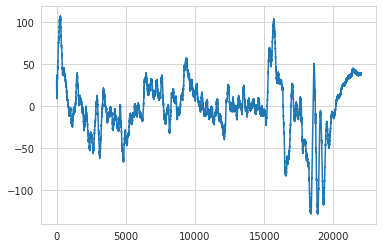

In [4]:
sns.lineplot(data=TRACES[0])

## TVLA

With 2 class evaluation. Method of the DL-LA paper.

In [5]:
# A: Low HW
A5 = TRACES[TVLA_BYTE]
# B: Random data
B5 = TRACES[np.invert(TVLA_BYTE)]

In [6]:
def random_split(x, fraction):
    """
    Splits the given array in two parts.
    - the first part is approximately of size n * (1 - fraction).
    - the second part is approximately of size n * fraction.
    """
    selection = np.random.random(len(x)) > fraction

    return x[selection], x[np.invert(selection)]

def random_divide(x):
    """
    Divides the given array in two equally sized parts.
    """
    left, right = random_split(x, .5)
    res_size = min(len(left), len(right))

    return left[:res_size], right[:res_size]

In [7]:
def mdiff(a, b):
    """
    Calculates the moment difference for all sample points,
    a predictive measure for the performance of an 1st order t-test.
    """
    def get_moment(x: np.array):
        return x.mean(axis=0, dtype=np.float128)

    a1, a2 = random_divide(a)
    _, b2 = random_divide(b)

    mdiff_in = np.abs(get_moment(a1) - get_moment(a2))
    mdiff_out = np.abs(get_moment(a1) - get_moment(b2))

    return mdiff_out - mdiff_in

MDIFF = mdiff(A5, B5)

<AxesSubplot:>

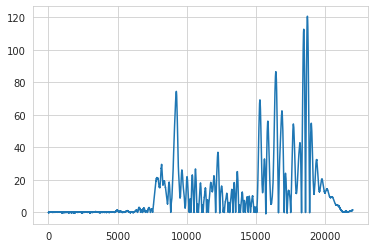

In [8]:
sns.lineplot(data=MDIFF)

In [9]:
TITLE = "A: Low hamming weight, B: Random\n"

def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    accumulator = TvlaAccu(a.shape[1], make_test=make_t_test)
    accumulator.add(a, b)

    return accumulator.p_gradient

P_GRADIENT_AB = cache_np('aisy/p_gradient_ab', min_p_gradient, A5, B5)
P_GRADIENT_BB = cache_np('aisy/p_gradient_bb', min_p_gradient, *random_divide(B5))

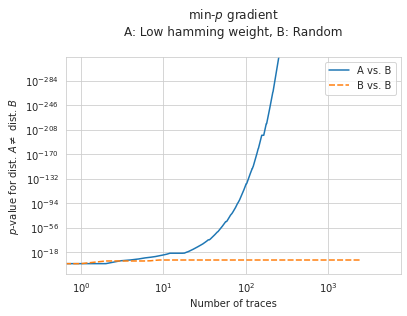

In [10]:
plot_p_gradient({"A vs. B": P_GRADIENT_AB, "B vs. B": P_GRADIENT_BB}, f"min-$p$ gradient\n{TITLE}")

## 2-class training

With 2 class evaluation

In [11]:
NUM_CLASSES = 2
TRACE_LEN = A5.shape[1]

def make_mlp_mini(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(TRACE_LEN,)))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=True)

    return out, mdl

def get_mini_model(args):
    return make_mlp_mini(*args, params={
        'activation':'relu',
        'optimizer': Adam(lr=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 1
    })[1]

In [12]:
def z_norm(x_profiling, x_attack):
    profiling_mean, profiling_var = x_profiling.mean(axis=0), x_profiling.var(axis=0)

    def normalize(x):
        return (x - profiling_mean) / profiling_var

    return normalize(x_profiling), normalize(x_attack)


def labelize(x, y: int, num_classes=NUM_CLASSES):
    return [to_categorical(y, num_classes),] * len(x)

def concat(a, b):
    return np.concatenate((a, b), axis=0)

def prepare_dlla(a, b):
    min_size = min(len(a), len(b))
    a, b = a[:min_size], b[:min_size]

    a_profile, a_attack = random_split(a, .2)
    b_profile, b_attack = random_split(b, .2)

    # Label traces using one-hot encoding.
    y_profiling = concat(labelize(a_profile, 0), labelize(b_profile, 1))
    y_attack = concat(labelize(a_attack, 0), labelize(b_attack, 1))

    # z-normalize traces based on Profiling mean and variance.
    x_profiling, x_attack = z_norm(concat(a_profile, b_profile), concat(a_attack, b_attack))

    # Randomize for good measure.
    ix_profiling, ix_attack = np.arange(len(x_profiling)), np.arange(len(x_attack))
    np.random.shuffle(ix_profiling)
    np.random.shuffle(ix_attack)

    return x_profiling[ix_profiling], y_profiling[ix_profiling], x_attack[ix_attack], y_attack[ix_attack]


AB_PREP = prepare_dlla(A5, B5)
MODEL_AB = get_mini_model(AB_PREP)

53/53 [==============================] - 1s 22ms/step - loss: 0.0838 - accuracy: 0.9471 - val_loss: 0.0384 - val_accuracy: 0.9970


In [13]:
BB_PREP = prepare_dlla(*random_divide(B5))
MODEL_BB = get_mini_model(BB_PREP)

27/27 [==============================] - 1s 18ms/step - loss: 0.9933 - accuracy: 0.5038 - val_loss: 0.9945 - val_accuracy: 0.4970


In [14]:
def z_test(validation_size, num_correct):
    """
    Approximation of a binomial test with success probability = 0.5.
    This simple version of the Z-test is accurate only for large sample sizes.
    """
    z_score = (num_correct - validation_size * .5) / np.sqrt(validation_size * .25)

    return norm.cdf(-z_score)

def binomial_test(validation_size, num_correct):
    """
    Binomial test with success probability = 0.5.
    Returns the p-value for hypotheses H0: validation accuracy ≤ 0.5,
        where the validation accuracy is calculated by (num_correct / validation_size).

    - validation_size refers to M from the DL-LA paper.
    - num_correct refers to s_M from the DL-LA paper.
    """
    p = 0
    for k in range(num_correct, validation_size + 1):
        # Binomial coefficient
        c = comb(validation_size, k)

        if c > 10 ** 32:
            # If the validation size is large (more than 1000 traces) p tends to go to infinite.
            # In this case, approximate the binomial test using z-test.
            return z_test(validation_size, num_correct)

        p += c

    p_value = p * .5 ** validation_size

    return p_value

def dlla_p_gradient(model: Model, x_attack: np.array, y_attack: np.array):
    total = 0
    total_correct = 0
    res = []

    for x, y in zip(model.predict(x_attack), y_attack):
        total += 1
        total_correct += x.argmax() == y.argmax()
        res.append(binomial_test(total, total_correct))

    return np.array(res)

In [15]:
DLLA_PG_AB = dlla_p_gradient(MODEL_AB, *AB_PREP[2:])
DLLA_PG_BB = dlla_p_gradient(MODEL_BB, *BB_PREP[2:])

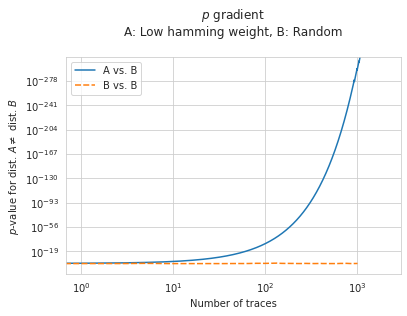

In [16]:
plot_p_gradient({"A vs. B": DLLA_PG_AB, "B vs. B": DLLA_PG_BB}, f"$p$ gradient\n{TITLE}")

## 9-class training

With 2 class evaluation

In [17]:
def hw_byte(plaintexts: np.array, keys: np.array, aes_round=4, target_byte=2):
    """
    Returns the hamming weight of the AES state at the given round and target byte indices.
    """
    states = full_states(plaintexts, keys)

    return states[:, aes_round, target_byte]

HAMMING_WEIGHTS = cache_np(F'aisy/hw_r5_b3', hw_byte, PLAINTEXT, KEY)

### TODO
1. Do 9 class train, 2 class LA on HW bytes from above.